- Filename: Eval-TrajGulfOfAntalya_Plot-Fig10Fig11.ipynb
- Author: Siren Rühs (s.ruhs@uu.nl)
- Created: June 2023
- Last updated: August 9th 2024
- Description: Jupyter notebook accompanying the manuscript "Non-negligible impact of Stokes drift and wave-driven Eulerian currents on simulated surface particle dispersal in the Mediterranean Sea" by Rühs et al., used to produce Figures 10 and 11 and Supplementary Figures S6 and S7

# Comparing virtual particle trajectories from ocean-only (non-coupled) and ocean-wave (coupled) model simulations for the Gulf of Antalya

## 1. General Settings

### 1.1 Load modules and check versions

In [1]:
from glob import glob

import numpy as np
import xarray as xr
from xhistogram.xarray import histogram

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import colors
from matplotlib import cm

import utils
from utils import ColorSettings as cparams
from utils import ReleaseBoxLimits as boxparams

In [2]:
utils.print_imported_package_versions(globals())

xarray==2022.12.0
matplotlib==3.6.2
numpy==1.24.1


### 1.2 Set input and output paths

In [3]:
datapath = '../data-proc/traj/SubReg14/'

gridpath = '../data-orig/'

outpath_figs = '../figs/'

### 1.3 Define custom parameters

In [4]:
# set zarrdata to False if Parcels_CalcTraj.ipynb has not been executed
# then the trajectory data in netcdf format will be loaded
zarrdata = True
# set tonetcdf to True if you want to save trajectory data in netcdf format
tonetcdf = False  

In [5]:
# tobs: timestep for which final statistics should be calculated and visualized
tobs = 30

# summer and winter slices based on release times
# (corresponding new variable in trajectory data set: start, see below in 2.)
summerslice = slice(31, 49)
l1 = np.arange(0, 12)
l2 = np.arange(67, 73)
l3 = [*l1, *l2]
winterslice = l3

In [6]:
col_blue = cparams.blue
col_cyan = cparams.cyan
col_green = cparams.green
col_yellow = cparams.yellow
col_red = cparams.red
col_purple = cparams.purple
col_grey = cparams.grey

## 2. Loading and formatting trajectory data

In [7]:

if zarrdata == True:
    trajpaths_csd = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-coupled-sd_Release-SubReg14-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                           key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_csd = xr.open_mfdataset(trajpaths_csd,
                                 concat_dim="start", combine="nested",
                                 engine="zarr")

    trajpaths_cnosd = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-coupled-nosd_Release-SubReg14-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                             key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_cnosd = xr.open_mfdataset(trajpaths_cnosd,
                                   concat_dim="start", combine="nested",
                                   engine="zarr")

    trajpaths_nc = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-uncoupled_Release-SubReg14-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                          key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_nc = xr.open_mfdataset(trajpaths_nc,
                                concat_dim="start", combine="nested",
                                engine="zarr")

    trajpaths_ncsd = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-uncoupled-sd_Release-SubReg14-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                            key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_ncsd = xr.open_mfdataset(trajpaths_ncsd,
                                  concat_dim="start", combine="nested",
                                  engine="zarr")
    if tonetcdf == True:
        traj_csd.to_netcdf(datapath + "Trajectories_BestGuess_coupled-sd.nc")
        traj_cnosd.to_netcdf(
            datapath + "Trajectories_Sensitivity_coupled-nosd.nc")
        traj_nc.to_netcdf(datapath + "Trajectories_OldStandard_uncoupled.nc")
        traj_ncsd.to_netcdf(
            datapath + "Trajectories_Approximation_uncoupled-sd.nc")
else:
    traj_csd = xr.open_dataset(
        datapath + "Trajectories_BestGuess_coupled-sd.nc")
    traj_cnosd = xr.open_dataset(
        datapath + "Trajectories_Sensitivity_coupled-nosd.nc")
    traj_nc = xr.open_dataset(
        datapath + "Trajectories_OldStandard_uncoupled.nc")
    traj_ncsd = xr.open_dataset(
        datapath + "Trajectories_Approximation_uncoupled-sd.nc")


# Grid

grid = xr.open_dataset(gridpath + 'mesh_mask.nc', drop_variables=("x", "y"))

In [8]:
traj_csd

<xarray.Dataset>
Dimensions:     (start: 73, trajectory: 1350, obs: 31)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30
  * trajectory  (trajectory) int64 0 1 2 3 4 5 ... 1344 1345 1346 1347 1348 1349
Dimensions without coordinates: start
Data variables:
    U           (start, trajectory, obs) float32 dask.array<chunksize=(1, 1350, 1), meta=np.ndarray>
    V           (start, trajectory, obs) float32 dask.array<chunksize=(1, 1350, 1), meta=np.ndarray>
    beached     (start, trajectory, obs) float64 dask.array<chunksize=(1, 1350, 1), meta=np.ndarray>
    lat         (start, trajectory, obs) float64 dask.array<chunksize=(1, 1350, 1), meta=np.ndarray>
    lon         (start, trajectory, obs) float64 dask.array<chunksize=(1, 1350, 1), meta=np.ndarray>
    time        (start, trajectory, obs) datetime64[ns] dask.array<chunksize=(1, 1350, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

## 3. Additional Analysis

 ### 3.1 Calculate Lagrangian velocity speed and direction along trajectory

In [9]:
def calc_trajspeed(trajset):
    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60
    speed = (u**2 + v**2)**(1/2)
    return speed

# calculation of unit vector current direction
def calc_trajveldir(trajset):
    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60
    veldir = 180 + 180/np.pi*(np.arctan2(-u,-v)) 
    return veldir

In [10]:
trajspeed_csd = calc_trajspeed(traj_csd)
trajspeed_cnosd = calc_trajspeed(traj_cnosd)
trajspeed_nc = calc_trajspeed(traj_nc)
trajspeed_ncsd = calc_trajspeed(traj_ncsd)

In [11]:
trajveldir_csd = calc_trajveldir(traj_csd)
trajveldir_cnosd = calc_trajveldir(traj_cnosd)
trajveldir_nc = calc_trajveldir(traj_nc)
trajveldir_ncsd = calc_trajveldir(traj_ncsd)

### 3.2 Check whether particles beached

In [12]:
def calc_npaticles_beached(trajset):
    tmp = trajset.beached.sum(dim=('obs'))
    beached_trajset = (tmp.where(tmp != 0) / tmp.where(tmp != 0)).sum()
    return beached_trajset.values

In [13]:
npart = traj_csd.lat.shape[0] * traj_csd.lat.shape[1]
print('Total number of released particles per dataset:', str(npart))
print('number of beached particles:')
print('coupled with Stokes drift:', str(calc_npaticles_beached(traj_csd)),
      ' (', str(round(calc_npaticles_beached(traj_csd)/npart*100)), '%)')
print('coupled without Stokes drift:', str(calc_npaticles_beached(traj_cnosd)),
      ' (', str(round(calc_npaticles_beached(traj_cnosd)/npart*100)), '%)' )
print('uncoupled without Stokes drift:', str(calc_npaticles_beached(traj_nc)),
      ' (', str(round(calc_npaticles_beached(traj_nc)/npart*100)), '%)' )
print('uncoupled with Stokes drift:', str(calc_npaticles_beached(traj_ncsd)),
      ' (', str(round(calc_npaticles_beached(traj_ncsd)/npart*100)), '%)' )

Total number of released particles per dataset: 98550
number of beached particles:
coupled with Stokes drift: 168.0  ( 0 %)
coupled without Stokes drift: 158.0  ( 0 %)
uncoupled without Stokes drift: 171.0  ( 0 %)
uncoupled with Stokes drift: 201.0  ( 0 %)


In [14]:
def calc_npaticles_stucked(trajspeed):
    tmp = xr.where(trajspeed <= 1e-8, trajspeed/trajspeed, trajspeed*0).sum(dim=('obs'))
    stucked_trajset = (tmp.where(tmp != 0) / tmp.where(tmp != 0)).sum()
    return stucked_trajset.values

In [15]:
print('number of stucked particles:')
tmp = calc_npaticles_stucked(trajspeed_csd)
print('coupled with Stokes drift:', str(tmp),
      ' (', str(round(tmp/npart*100)), '%)')
tmp = calc_npaticles_stucked(trajspeed_cnosd)
print('coupled without Stokes drift:', str(tmp),
      ' (', str(round(tmp/npart*100)), '%)' )
tmp = calc_npaticles_stucked(trajspeed_nc)
print('uncoupled without Stokes drift:', str(tmp),
      ' (', str(round(tmp/npart*100)), '%)' )
tmp = calc_npaticles_stucked(trajspeed_ncsd)
print('uncoupled with Stokes drift:', str(tmp),
      ' (', str(round(tmp/npart*100)), '%)' )

number of stucked particles:


/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


coupled with Stokes drift: 128.0  ( 0 %)


/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


coupled without Stokes drift: 114.0  ( 0 %)


/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


uncoupled without Stokes drift: 130.0  ( 0 %)


/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


uncoupled with Stokes drift: 150.0  ( 0 %)


### 3.3  Calculate general dispersal statistics: along-track distance and net displacement, print values for Table 3

In [16]:
# Geographical distance

# (this function is partially from Laura)
def dist_km(lona, lonb, lata, latb):

    # convert degrees in radians
    lat1 = np.radians(lata)
    lon1 = np.radians(lona)
    lat2 = np.radians(latb)
    lon2 = np.radians(lonb)

    # haversine formula
    # i.e. calculate distance on a sphere
    R = 6373.0 # approximate radius of earth in km
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

In [17]:
# Along-track velocity averaged along each trajectory

def calc_LAvel_tmean(trajspeed):
    trajspeed_tmean = trajspeed.mean(dim='obs')
    return trajspeed_tmean


# Magnitude of (net) displacement in km

def displacement(trajset,tobs):

    lona = trajset.isel(obs=0).lon
    lonb = trajset.isel(obs=tobs).lon
    lata = trajset.isel(obs=0).lat
    latb = trajset.isel(obs=tobs).lat

    disp = xr.apply_ufunc(dist_km, lona, lonb, lata, latb, dask="allowed") 

    return disp


# Direction of (net) displacement

def displacement_dir(trajset,tobs):

    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60
    u_tint = u.isel(obs=slice(0,tobs+1)).cumsum(dim='obs', skipna=True)
    v_tint = v.isel(obs=slice(0,tobs+1)).cumsum(dim='obs', skipna=True)

    dispdir = 180 + 180/np.pi*np.arctan2(-u_tint,-v_tint)
    
    return dispdir  


# along-track distance (also called cumulative distance) in m

def distance(trajspeed,dtout):
    #dtout is the output frequency in seconds
    # 1. Cumulative displacement for each particle
    ## obtained by integrating over along-track velocities
    partdist = trajspeed * dtout
    dist = (partdist.cumsum(dim='obs', skipna=True)) 

    return partdist, dist

In [18]:
trajspeed_tmean_csd = calc_LAvel_tmean(trajspeed_csd)
trajspeed_tmean_cnosd = calc_LAvel_tmean(trajspeed_cnosd)
trajspeed_tmean_nc = calc_LAvel_tmean(trajspeed_nc)
trajspeed_tmean_ncsd = calc_LAvel_tmean(trajspeed_ncsd)


In [19]:
traj_disp30d_csd = displacement(traj_csd, tobs)
traj_disp30d_cnosd = displacement(traj_cnosd, tobs)
traj_disp30d_nc = displacement(traj_nc, tobs)
traj_disp30d_ncsd = displacement(traj_ncsd, tobs)

In [20]:
traj_dispdir30d_csd = displacement_dir(traj_csd, tobs)
traj_dispdir30d_cnosd = displacement_dir(traj_cnosd, tobs)
traj_dispdir30d_nc = displacement_dir(traj_nc, tobs)
traj_dispdir30d_ncsd = displacement_dir(traj_ncsd, tobs)


In [21]:
partdist_csd, dist_csd = distance(trajspeed_csd, 86400)
partdist_cnosd, dist_cnosd = distance(trajspeed_cnosd, 86400)
partdist_nc, dist_nc = distance(trajspeed_nc, 86400)
partdist_ncsd, dist_ncsd = distance(trajspeed_ncsd, 86400)

In [22]:
# Calculate means and standard deviations of the variables for the different seasons

def calc_print_meanstd_seasons(var):
    def get_season_stats(var, slice_=None):
        if slice_ is None:  # Handle the 'annual' case separately
            stacked_var = var.rename('dist').stack(trajstack=('trajectory', 'start'))
        else:
            stacked_var = var.rename('dist').isel(start=slice_).stack(trajstack=('trajectory', 'start'))
        return stacked_var.mean(), stacked_var.std()
    
    slices = {
        'annual': None,
        'summer': summerslice,
        'winter': winterslice
    }
    
    stats = {}
    for season, slice_ in slices.items():
        mean, std = get_season_stats(var, slice_)
        stats[season] = (mean, std)
        print(f'{season}: {np.round(mean.values, 2)} +/- {np.round(std.values, 2)} km')
    
    return stats

def process_var(var_name, var):
    print(var_name)
    return calc_print_meanstd_seasons(var)


# Calculate errors for approximation and old standard
# i.e., the difference between the coupled/approximated and uncoupled simulations

def calculate_print_errors(label, nc, csd):
      diff = np.round(nc.values - csd.values, 2)
      percent = np.round((diff / csd.values) * 100, 2)
      print(f'{label}: {diff} ({percent}%)')


In [23]:
print('Along-track distance')

dist_nc_stats = process_var('Old standard', dist_nc.isel(obs=tobs)/1000)
dist_csd_stats = process_var('Best guess', dist_csd.isel(obs=tobs)/1000)
dist_ncsd_stats = process_var('Approximation', dist_ncsd.isel(obs=tobs)/1000)

print('Error Old standard:')
calculate_print_errors('Annual', dist_nc_stats['annual'][0], dist_csd_stats['annual'][0])
calculate_print_errors('Summer', dist_nc_stats['summer'][0], dist_csd_stats['summer'][0])
calculate_print_errors('Winter', dist_nc_stats['winter'][0], dist_csd_stats['winter'][0])

print('Error Approximation:')
calculate_print_errors('Annual', dist_ncsd_stats['annual'][0], dist_csd_stats['annual'][0])
calculate_print_errors('Summer', dist_ncsd_stats['summer'][0], dist_csd_stats['summer'][0])
calculate_print_errors('Winter', dist_ncsd_stats['winter'][0], dist_csd_stats['winter'][0])

Along-track distance
Old standard
annual: 416.75 +/- 179.45 km
summer: 406.71 +/- 150.66 km
winter: 463.29 +/- 218.55 km
Best guess
annual: 406.98 +/- 193.6 km
summer: 371.32 +/- 152.16 km
winter: 469.75 +/- 227.73 km
Approximation
annual: 415.24 +/- 177.71 km
summer: 400.61 +/- 145.34 km
winter: 474.16 +/- 215.8 km
Error Old standard:
Annual: 9.78 (2.4%)
Summer: 35.39 (9.53%)
Winter: -6.46 (-1.38%)
Error Approximation:
Annual: 8.26 (2.03%)
Summer: 29.29 (7.89%)
Winter: 4.41 (0.94%)


In [24]:
print('Magnitude of net displacement')

traj_disp30d_nc_stats = process_var('Old standard', traj_disp30d_nc)
traj_disp30d_csd_stats = process_var('Best guess', traj_disp30d_csd)
traj_disp30d_ncsd_stats = process_var('Approximation', traj_disp30d_ncsd)

print('Error Old standard:')
calculate_print_errors('annual', traj_disp30d_nc_stats['annual'][0], traj_disp30d_csd_stats['annual'][0])
calculate_print_errors('summer', traj_disp30d_nc_stats['summer'][0], traj_disp30d_csd_stats['summer'][0])
calculate_print_errors('winter', traj_disp30d_nc_stats['winter'][0], traj_disp30d_csd_stats['winter'][0])

print('Error Approximation:')
calculate_print_errors('annual', traj_disp30d_ncsd_stats['annual'][0], traj_disp30d_csd_stats['annual'][0])
calculate_print_errors('summer', traj_disp30d_ncsd_stats['summer'][0], traj_disp30d_csd_stats['summer'][0])
calculate_print_errors('winter', traj_disp30d_ncsd_stats['winter'][0], traj_disp30d_csd_stats['winter'][0])


Magnitude of net displacement
Old standard
annual: 213.2 +/- 135.31 km
summer: 210.03 +/- 114.81 km
winter: 262.51 +/- 158.09 km
Best guess
annual: 214.3 +/- 143.39 km
summer: 191.21 +/- 108.25 km
winter: 263.88 +/- 170.04 km
Approximation
annual: 206.62 +/- 133.0 km
summer: 196.78 +/- 109.72 km
winter: 262.16 +/- 159.66 km
Error Old standard:
annual: -1.1 (-0.51%)
summer: 18.83 (9.85%)
winter: -1.37 (-0.52%)
Error Approximation:
annual: -7.68 (-3.58%)
summer: 5.58 (2.92%)
winter: -1.72 (-0.65%)


## 4. Visualize results

In [25]:
# Define general plotting parameters and custom plotting functions

fs = 'small'
fs2 = 'x-small'

lw1 = 1.5
lw_box = 0.8

col_csd = 'k'
col_nc = col_grey
col_ncsd = col_purple
col_euler = col_yellow
col_stokes = col_blue
col_approx = col_cyan
col_total = col_red


def calc_hists(var1, var2, var3, var4):
    # var1: best guess (csd)
    # var2: sensitivity (cnosd)
    # var3: old standard (nc)
    # var4: approximation (ncsd)

    hist1 = histogram(var1, bins=[bins])
    hist2 = histogram(var2, bins=[bins])
    hist3 = histogram(var3, bins=[bins])
    hist4 = histogram(var4, bins=[bins])
    hist1b = hist1/hist1.sum()*100
    hist2b = hist2/hist2.sum()*100
    hist3b = hist3/hist3.sum()*100
    hist4b = hist4/hist4.sum()*100

    return hist1b, hist2b, hist3b, hist4b


def plot_histcounts(ax, xlim, ylim, ytick, binwidth, hist1b, hist3b):
    plt.bar(hist3b.dist_bin-binwidth/2, hist3b.values,
            width=binwidth, color=col_nc,
            label='old standard')
    plt.bar(hist1b.dist_bin+binwidth/2, hist1b.values,
            width=binwidth, color=col_csd,
            label='best guess')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yticks(ytick)


def plot_histdiff(ax2, xlim, ylim, ytick, yticklab, hist1b, hist2b, hist3b, hist4b):
    ax2.plot(hist1b.dist_bin, hist1b.dist_bin*0,
             color='k', linewidth=0.5)
    ax2.plot(hist1b.dist_bin, hist1b-hist3b,
             color=col_total, linewidth=lw1, label='total')
    ax2.plot(hist1b.dist_bin, hist2b-hist3b,
             color=col_euler, linewidth=lw1, label='Eulerian currents')
    ax2.plot(hist1b.dist_bin, hist1b-hist2b,
             color=col_stokes, linewidth=lw1, label='Stokes drift')
    ax2.plot(hist1b.dist_bin, hist4b-hist3b,
             color=col_approx, linewidth=lw1, label='approximation')
    ax2.plot(hist1b.dist_bin, hist1b-hist2b,
             color=col_stokes, linewidth=lw1)
    ax2.plot(hist1b.dist_bin, hist1b-hist3b,
             color=col_total, linewidth=lw1)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.set_yticks(ytick)
    ax2.set_yticklabels(yticklab)

Text(450, 0, 'Frequency \n change [%]')

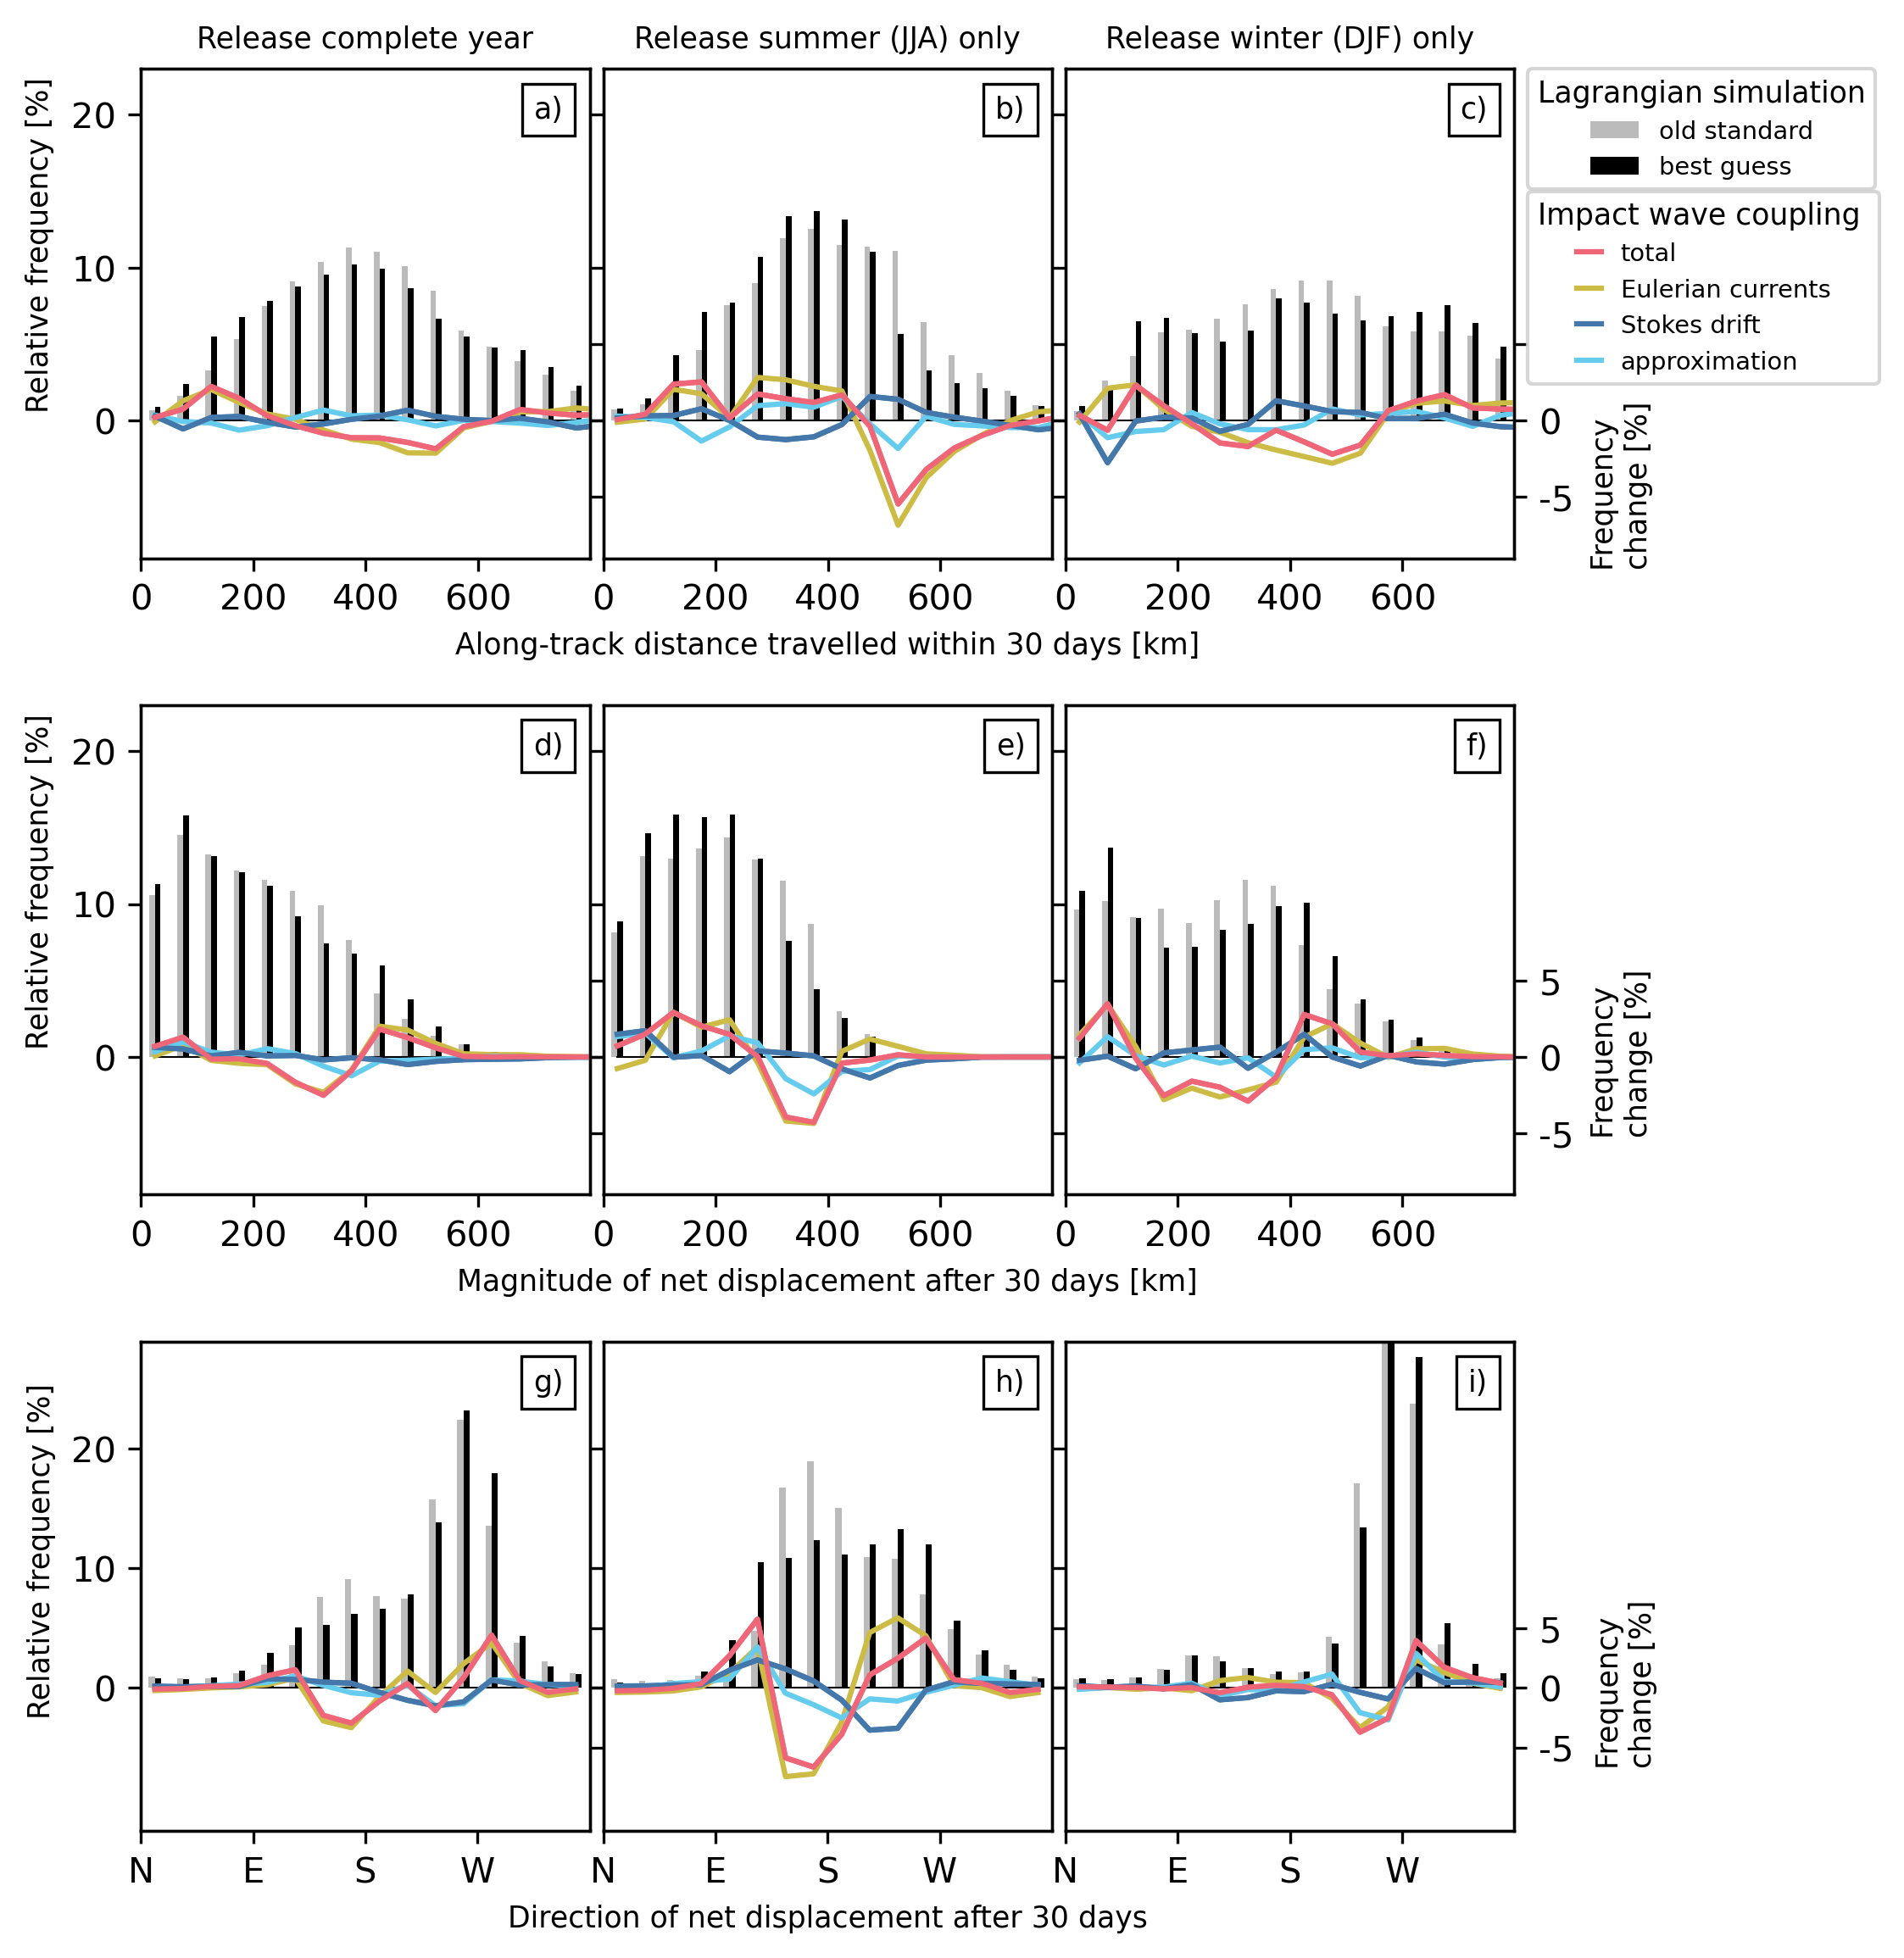

In [26]:
# Do the actual plotting


fig = plt.figure(figsize=(6, 9), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=3,
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.3)


#######################################################
# Cumulative displacement/ along-track distance


bins = np.arange(0,950,50)
bar_width = 10
xlims = [0,799]
ylims = [-9,23]
yticks = [0,10,20]
yticks2 = [-5,0,5]
yticklabs2 = ['-5','0','']


# Distribution release whole year

# Calculate histograms
var1 = dist_csd.rename('dist').isel(obs=tobs).stack(
    trajstack=('trajectory', 'start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs).stack(
    trajstack=('trajectory', 'start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs).stack(
    trajstack=('trajectory', 'start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs).stack(
    trajstack=('trajectory', 'start'))/1000
hist1b, hist2b, hist3b, hist4b = calc_hists(var1, var2, var3, var4)

# Plot bars (old standard, best guess)
ax = fig.add_subplot(gs[0, 0])
plot_histcounts(ax, binwidth=bar_width,
                xlim=xlims, ylim=ylims,
                ytick=yticks,
                hist1b=hist1b, hist3b=hist3b)
ax.text(-180, 11.5, 'Relative frequency [%]',
        fontsize=fs, rotation=90, ha='center', va='center')
ax.set_title('Release complete year', fontsize=fs)
utils.label_subplot(ax, 'a)', fs=fs, lw=lw_box, loc='upper right')

# Plot lines (wave impact)
ax2 = ax.twinx()
plot_histdiff(ax2,
              xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2,
              hist1b=hist1b, hist2b=hist2b, hist3b=hist3b, hist4b=hist4b)


# Distribution summer

# Calculate histograms
var1 = dist_csd.rename('dist').isel(obs=tobs, start=summerslice).stack(trajstack=('trajectory', 'start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs, start=summerslice).stack(trajstack=('trajectory', 'start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs, start=summerslice).stack(trajstack=('trajectory', 'start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs, start=summerslice).stack(trajstack=('trajectory', 'start'))/1000
hist1b, hist2b, hist3b, hist4b = calc_hists(var1, var2, var3, var4)

# Plot bars (old standard, best guess)
ax = fig.add_subplot(gs[0, 1])
plot_histcounts(ax, binwidth=bar_width,
                xlim=xlims, ylim=ylims,
                ytick=yticks,
                hist1b=hist1b, hist3b=hist3b)
ax.set_yticklabels([])
ax.set_title('Release summer (JJA) only', fontsize=fs)
ax.set_xlabel(
    'Along-track distance travelled within 30 days [km]', fontsize=fs)
utils.label_subplot(ax, 'b)', fs=fs, lw=lw_box, loc='upper right')

# Plot lines (wave impact)
ax2 = ax.twinx()
plot_histdiff(ax2,
              xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2,
              hist1b=hist1b, hist2b=hist2b, hist3b=hist3b, hist4b=hist4b)
ax2.set_yticklabels([])


# Distribution winter

# Calculate histograms
var1 = dist_csd.rename('dist').isel(obs=tobs, start=winterslice).stack(
    trajstack=('trajectory', 'start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs, start=winterslice).stack(
    trajstack=('trajectory', 'start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs, start=winterslice).stack(
    trajstack=('trajectory', 'start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs, start=winterslice).stack(
    trajstack=('trajectory', 'start'))/1000
hist1b, hist2b, hist3b, hist4b = calc_hists(var1, var2, var3, var4)

# Plot bars (old standard, best guess)
ax = fig.add_subplot(gs[0, 2])
plot_histcounts(ax, binwidth=bar_width,
                xlim=xlims, ylim=ylims,
                ytick=yticks,
                hist1b=hist1b, hist3b=hist3b)
ax.set_yticklabels([])
ax.set_title('Release winter (DJF) only', fontsize=fs)
ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left',
          title="Lagrangian simulation", title_fontsize=fs,
          borderaxespad=0., fontsize=fs2)
utils.label_subplot(ax, 'c)', fs=fs, lw=lw_box, loc='upper right')

# Plot lines (wave impact)
ax2 = ax.twinx()
plot_histdiff(ax2,
              xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2,
              hist1b=hist1b, hist2b=hist2b, hist3b=hist3b, hist4b=hist4b)
ax2.legend(bbox_to_anchor=(1.03, 0.75), loc='upper left',
           title='Impact wave coupling ', title_fontsize=fs,
           borderaxespad=0., fontsize=fs2,
           handlelength=1)
ax.text(990, -4.5, 'Frequency \n change [%]',
        fontsize=fs, rotation=90, ha='center', va='center')


#######################################################
# Magnitude net displacement


bins = np.arange(0, 950, 50)
bar_width = 10
yticklabs2 = ['-5', '0', '5']


# Distribution release whole year

# Calculate histograms
var1 = traj_disp30d_csd.rename('dist').stack(trajstack=('trajectory', 'start'))
var2 = traj_disp30d_cnosd.rename('dist').stack(
    trajstack=('trajectory', 'start'))
var3 = traj_disp30d_nc.rename('dist').stack(trajstack=('trajectory', 'start'))
var4 = traj_disp30d_ncsd.rename('dist').stack(
    trajstack=('trajectory', 'start'))
hist1b, hist2b, hist3b, hist4b = calc_hists(var1, var2, var3, var4)

# Plot bars (old standard, best guess)
ax = fig.add_subplot(gs[1, 0])
plot_histcounts(ax, binwidth=bar_width,
                xlim=xlims, ylim=ylims,
                ytick=yticks,
                hist1b=hist1b, hist3b=hist3b)
ax.text(-180, 11.5, 'Relative frequency [%]',
        fontsize=fs, rotation=90, ha='center', va='center')
utils.label_subplot(ax, 'd)', fs=fs, lw=lw_box, loc='upper right')

# Plot lines (wave impact)
ax2 = ax.twinx()
plot_histdiff(ax2,
              xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2,
              hist1b=hist1b, hist2b=hist2b, hist3b=hist3b, hist4b=hist4b)


# Distribution summer

# Calculate histograms
var1 = traj_disp30d_csd.rename('dist').isel(
    start=summerslice).stack(trajstack=('trajectory', 'start'))
var2 = traj_disp30d_cnosd.rename('dist').isel(
    start=summerslice).stack(trajstack=('trajectory', 'start'))
var3 = traj_disp30d_nc.rename('dist').isel(
    start=summerslice).stack(trajstack=('trajectory', 'start'))
var4 = traj_disp30d_ncsd.rename('dist').isel(
    start=summerslice).stack(trajstack=('trajectory', 'start'))
hist1b, hist2b, hist3b, hist4b = calc_hists(var1, var2, var3, var4)

# Plot bars (old standard, best guess)
ax = fig.add_subplot(gs[1, 1])
plot_histcounts(ax, binwidth=bar_width,
                xlim=xlims, ylim=ylims,
                ytick=yticks,
                hist1b=hist1b, hist3b=hist3b)
ax.set_yticklabels([])
ax.set_xlabel('Magnitude of net displacement after 30 days [km]', fontsize=fs)
utils.label_subplot(ax, 'e)', fs=fs, lw=lw_box, loc='upper right')

# Plot lines (wave impact)
ax2 = ax.twinx()
plot_histdiff(ax2,
              xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2,
              hist1b=hist1b, hist2b=hist2b, hist3b=hist3b, hist4b=hist4b)
ax2.set_yticklabels([])


# Distribution winter

# Calculate histograms
var1 = traj_disp30d_csd.rename('dist').isel(
    start=winterslice).stack(trajstack=('trajectory', 'start'))
var2 = traj_disp30d_cnosd.rename('dist').isel(
    start=winterslice).stack(trajstack=('trajectory', 'start'))
var3 = traj_disp30d_nc.rename('dist').isel(
    start=winterslice).stack(trajstack=('trajectory', 'start'))
var4 = traj_disp30d_ncsd.rename('dist').isel(
    start=winterslice).stack(trajstack=('trajectory', 'start'))
hist1b, hist2b, hist3b, hist4b = calc_hists(var1, var2, var3, var4)

# Plot bars (old standard, best guess)
ax = fig.add_subplot(gs[1, 2])
plot_histcounts(ax, binwidth=bar_width,
                xlim=xlims, ylim=ylims,
                ytick=yticks,
                hist1b=hist1b, hist3b=hist3b)
ax.set_yticklabels([])
utils.label_subplot(ax, 'f)', fs=fs, lw=lw_box, loc='upper right')

# Plot lines (wave impact)
ax2 = ax.twinx()
plot_histdiff(ax2,
              xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2,
              hist1b=hist1b, hist2b=hist2b, hist3b=hist3b, hist4b=hist4b)
ax.text(990, 0, 'Frequency \n change [%]',
        fontsize=fs, rotation=90, ha='center', va='center')


#######################################################
# Direction of net displacement


bins = np.arange(0, 380.5, 22.5)
bar_width = 5
tobs = 30
xlims = [0, 360]
ylims = [-12, 29]
yticks = [0, 10, 20]
yticks2 = [-5, 0, 5]
yticklabs2 = ['-5', '0', '5']
xticks = [0, 90, 180, 270]
xticklabs = ['N', 'E', 'S', 'W']


# Distribution release whole year

# Calculate histograms
var1 = traj_dispdir30d_csd.rename('dist').isel(
    obs=30).stack(trajstack=('trajectory', 'start'))
var2 = traj_dispdir30d_cnosd.rename('dist').isel(
    obs=30).stack(trajstack=('trajectory', 'start'))
var3 = traj_dispdir30d_nc.rename('dist').isel(
    obs=30).stack(trajstack=('trajectory', 'start'))
var4 = traj_dispdir30d_ncsd.rename('dist').isel(
    obs=30).stack(trajstack=('trajectory', 'start'))
hist1b, hist2b, hist3b, hist4b = calc_hists(var1, var2, var3, var4)

# Plot bars (old standard, best guess)
ax = fig.add_subplot(gs[2, 0])
plot_histcounts(ax, binwidth=bar_width,
                xlim=xlims, ylim=ylims,
                ytick=yticks,
                hist1b=hist1b, hist3b=hist3b)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
ax.text(-80, 11.5, 'Relative frequency [%]',
        fontsize=fs, rotation=90, ha='center', va='center')
utils.label_subplot(ax, 'g)', fs=fs, lw=lw_box, loc='upper right')

# Plot lines (wave impact)
ax2 = ax.twinx()
plot_histdiff(ax2,
              xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2,
              hist1b=hist1b, hist2b=hist2b, hist3b=hist3b, hist4b=hist4b)


# Distribution summer

# Calculate histograms
var1 = traj_dispdir30d_csd.rename('dist').isel(
    start=summerslice, obs=30).stack(trajstack=('trajectory', 'start'))
var2 = traj_dispdir30d_cnosd.rename('dist').isel(
    start=summerslice, obs=30).stack(trajstack=('trajectory', 'start'))
var3 = traj_dispdir30d_nc.rename('dist').isel(
    start=summerslice, obs=30).stack(trajstack=('trajectory', 'start'))
var4 = traj_dispdir30d_ncsd.rename('dist').isel(
    start=summerslice, obs=30).stack(trajstack=('trajectory', 'start'))
hist1b, hist2b, hist3b, hist4b = calc_hists(var1, var2, var3, var4)

# Plot bars (old standard, best guess)
ax = fig.add_subplot(gs[2, 1])
plot_histcounts(ax, binwidth=bar_width,
                xlim=xlims, ylim=ylims,
                ytick=yticks,
                hist1b=hist1b, hist3b=hist3b)
ax.set_yticklabels([])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
ax.set_xlabel('Direction of net displacement after 30 days', fontsize=fs)
utils.label_subplot(ax, 'h)', fs=fs, lw=lw_box, loc='upper right')

# Plot lines (wave impact)
ax2 = ax.twinx()
plot_histdiff(ax2,
              xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2,
              hist1b=hist1b, hist2b=hist2b, hist3b=hist3b, hist4b=hist4b)
ax2.set_yticklabels([])


# Distribution winter

# Calculate histograms
var1 = traj_dispdir30d_csd.rename('dist').isel(
    start=l3, obs=30).stack(trajstack=('trajectory', 'start'))
var2 = traj_dispdir30d_cnosd.rename('dist').isel(
    start=l3, obs=30).stack(trajstack=('trajectory', 'start'))
var3 = traj_dispdir30d_nc.rename('dist').isel(
    start=l3, obs=30).stack(trajstack=('trajectory', 'start'))
var4 = traj_dispdir30d_ncsd.rename('dist').isel(
    start=l3, obs=30).stack(trajstack=('trajectory', 'start'))
hist1b, hist2b, hist3b, hist4b = calc_hists(var1, var2, var3, var4)

ax = fig.add_subplot(gs[2, 2])
plot_histcounts(ax, binwidth=bar_width,
                xlim=xlims, ylim=ylims,
                ytick=yticks,
                hist1b=hist1b, hist3b=hist3b)
ax.set_yticklabels([])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
utils.label_subplot(ax, 'i)', fs=fs, lw=lw_box, loc='upper right')

ax2 = ax.twinx()
plot_histdiff(ax2,
              xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2,
              hist1b=hist1b, hist2b=hist2b, hist3b=hist3b, hist4b=hist4b)
ax.text(450, 0, 'Frequency \n change [%]',
        fontsize=fs, rotation=90, ha='center', va='center')

In [27]:
# Save the figure

fig.savefig('../figs/png/fig11.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
fig.savefig('../figs/png-transparent/fig11.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1,
            transparent=True)

Text(0.5, 0, 'direction displacement')

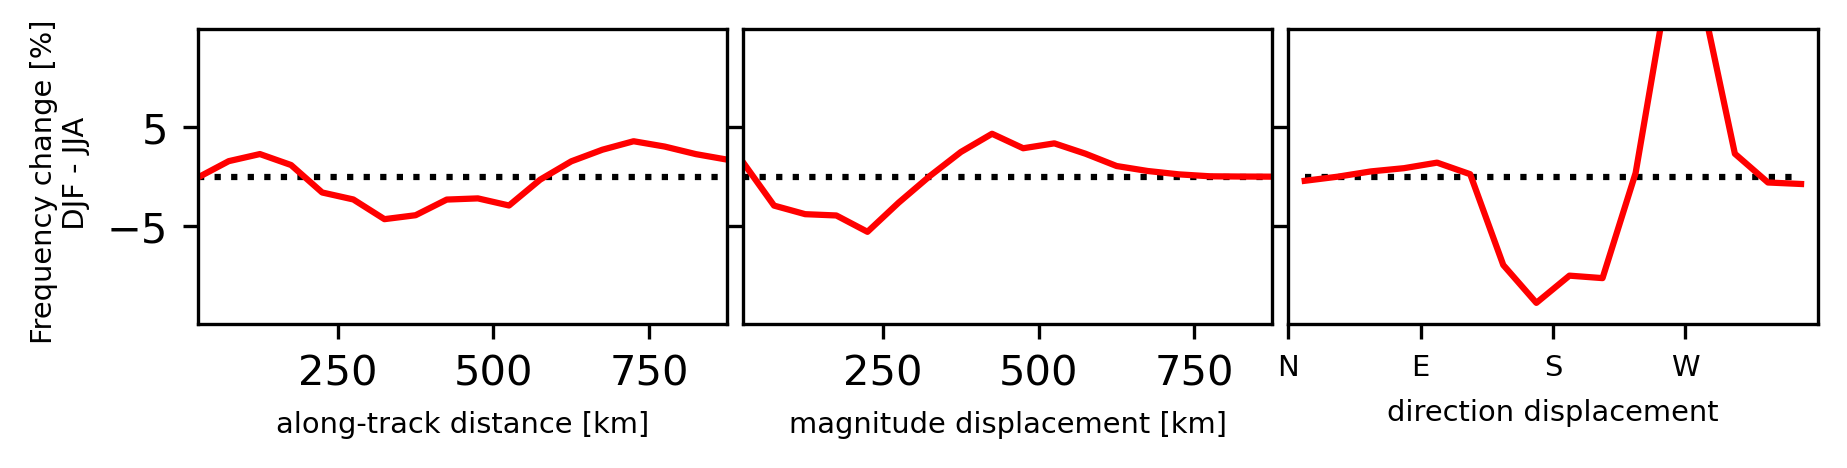

In [28]:
# Plot seasonal differences for best guess simulation
# (helpful for the manuscript)

fs = 'x-small'

def plot_histdiww_season(varS, varW, bins):
    histS = histogram(varS, bins=[bins])
    histSb = histS/histS.sum()*100
    histW = histogram(varW, bins=[bins])
    histWb = histW/histW.sum()*100
    ax.plot(histWb.dist_bin, histWb.dist_bin*0,
            color='k', linestyle='dotted', linewidth=lw1)
    ax.plot(histWb.dist_bin, histWb-histSb,
            color='r', linewidth=lw1)


fig = plt.figure(figsize=(6, 5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3,
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)

ax = fig.add_subplot(gs[2, 0])
bins = np.arange(0, 950, 50)
varS = dist_nc.rename('dist').isel(obs=30, start=slice(
    31, 49)).stack(trajstack=('trajectory', 'start'))/1000
varW = dist_nc.rename('dist').isel(obs=30, start=l3).stack(
    trajstack=('trajectory', 'start'))/1000
plot_histdiww_season(varS, varW, bins)
ax.set_xlim([25, 875])
ax.set_ylim([-15, 15])
ax.set_yticks([-5, 5])
ax.set_ylabel('Frequency change [%] \n DJF - JJA', fontsize=fs)
ax.set_xlabel('along-track distance [km]', fontsize=fs)

ax = fig.add_subplot(gs[2, 1])
varS = traj_disp30d_nc.rename('dist').isel(
    start=slice(31, 49)).stack(trajstack=('trajectory', 'start'))
varW = traj_disp30d_nc.rename('dist').isel(
    start=l3).stack(trajstack=('trajectory', 'start'))
plot_histdiww_season(varS, varW, bins)
ax.set_xlim([25, 875])
ax.set_ylim([-15, 15])
ax.set_yticks([-5, 5])
ax.set_yticklabels([])
ax.set_xlabel('magnitude displacement [km]', fontsize=fs)

ax = fig.add_subplot(gs[2, 2])
bins = np.arange(0, 380.5, 22.5)
varS = traj_dispdir30d_nc.rename('dist').isel(
    start=slice(31, 49)).stack(trajstack=('trajectory', 'start'))
varW = traj_dispdir30d_nc.rename('dist').isel(
    start=l3).stack(trajstack=('trajectory', 'start'))
plot_histdiww_season(varS, varW, bins)
ax.set_xlim([0, 360])
xticks = [0, 90, 180, 270]
xticklabs = ['N', 'E', 'S', 'W']
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs, fontsize=fs)
ax.set_ylim([-15, 15])
ax.set_yticks([-5, 5])
ax.set_yticklabels([])
ax.set_xlabel('direction displacement', fontsize=fs)

In [29]:
releasename='SubReg14'

lonmin_plot = 23
lonmax_plot = 35
latmin_plot = 30.5
latmax_plot = 40.5

lonmin = boxparams(release_name=releasename).lonmin
lonmax = boxparams(release_name=releasename).lonmax
latmin = boxparams(release_name=releasename).latmin
latmax = boxparams(release_name=releasename).latmax

lon_text_retention = 31
lat_text_retention = 38.5
lon_text_disparea = 26.5
lat_text_disparea = 32.5


xticks = [25, 29, 33]
yticks = [34, 38]
xticklabs = ['25° E', '29° E', '33° E']
yticklabs = ['34° N', '38° N']

step = 0.2
bins_lon = np.arange(-6, 36, step)
bins_lat = np.arange(30.1, 47, step)
highproblev = 90
nctic = 3

lw_box = 0.8
fs = 'xx-small'

colm_hist = cm.viridis
levs_hist = np.arange(0, 1.1, 0.1)
norm_hist = colors.BoundaryNorm(boundaries=levs_hist, ncolors=colm_hist.N)

colm_histdiff = cm.RdBu_r
levs_histdiff = np.arange(-0.8, 0.8, 0.1)
norm_histdiff = colors.BoundaryNorm(boundaries=levs_histdiff+0.05, ncolors=colm_histdiff.N)


In [30]:
def create_newfig():
    fig = plt.figure(figsize=(6, 5.3), dpi=300, constrained_layout=False)
    gs = fig.add_gridspec(nrows=4, ncols=3,
                          left=0.1, right=0.8,
                          top=0.8,
                          wspace=0.04, hspace=0.05)
    gscbar = fig.add_gridspec(nrows=4, ncols=100,
                              left=0.1, right=1,
                              top=0.8,
                              wspace=0.04, hspace=0.05)
    return fig, gs, gscbar


def axis_settings(xticklabel=True, yticklabel=True):
    ax.set_xlim([lonmin_plot, lonmax_plot])
    ax.set_ylim([latmin_plot, latmax_plot])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticklabels(yticklabs)
    if xticklabel == False:
        ax.set_xticklabels([])
    if yticklabel == False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)


def _plot_highprob(var1):
    pos_y = var1.isel(obs=tobs).lat.stack(trajstack=('trajectory', 'start'))
    pos_x = var1.isel(obs=tobs).lon.stack(trajstack=('trajectory', 'start'))
    hist2D = histogram(pos_x, pos_y, bins=[bins_lon, bins_lat])
    hist2D_plot = hist2D.transpose()/hist2D.sum().values*100
    tmp2 = np.sort(hist2D_plot.stack(binstack=('lon_bin', 'lat_bin')))
    tmp3 = np.cumsum(tmp2)
    highprob = xr.DataArray(tmp2).where(
    tmp3 >= highproblev).squeeze(drop=True).min()
    ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
              hist2D_plot.where(hist2D_plot >= highprob),
              alpha=1.0, edgecolor='k', facecolor='none',
              linewidth=0.5,
              shading='nearest')
    
    
def plot_2Dhist(var1):
    pos_y = var1.isel(obs=tobs).lat.stack(trajstack=('trajectory', 'start'))
    pos_x = var1.isel(obs=tobs).lon.stack(trajstack=('trajectory', 'start'))
    hist2D = histogram(pos_x, pos_y, bins=[bins_lon, bins_lat])
    hist2D_plot = hist2D.transpose()/hist2D.sum().values*100
    map = ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
                    hist2D_plot.where(hist2D_plot != 0),
                    cmap=colm_hist, norm=norm_hist,
                    shading='nearest')
    release_box = (((hist2D_plot.lon_bin >= lonmin) & (hist2D_plot.lon_bin <= lonmax)) &
                   ((hist2D_plot.lat_bin >= latmin) & (hist2D_plot.lat_bin <= latmax)))
    tmp = hist2D_plot.where(release_box)
    retention = tmp.sum()
    ax.text(lon_text_retention, lat_text_retention, 'retention:\n' + str(retention.round().values) + ' %', fontsize=5.5,
            ha='center', va='center')
    area_bins = (hist2D_plot.where(hist2D_plot != 0) /
                 hist2D_plot.where(hist2D_plot != 0)).sum()
    ax.text(lon_text_disparea, lat_text_disparea, 'dispersal area:\n ' + str(int(area_bins.round().values)) + ' bins', fontsize=5.5,
            ha='center', va='center')
    del tmp
    return map


def plot_2Dhistdiff(var1, var2):
    pos_1y = var1.isel(obs=30).lat.stack(trajstack=('trajectory', 'start'))
    pos_1x = var1.isel(obs=30).lon.stack(trajstack=('trajectory', 'start'))
    hist2D_1 = histogram(pos_1x, pos_1y, bins=[bins_lon, bins_lat])
    hist2D_plot_1 = hist2D_1.transpose()/hist2D_1.sum().values*100
    pos_2y = var2.isel(obs=30).lat.stack(trajstack=('trajectory', 'start'))
    pos_2x = var2.isel(obs=30).lon.stack(trajstack=('trajectory', 'start'))
    hist2D_2 = histogram(pos_2x, pos_2y, bins=[bins_lon, bins_lat])
    hist2D_plot_2 = hist2D_2.transpose()/hist2D_2.sum().values*100
    hist2ddiff = hist2D_plot_1 - hist2D_plot_2
    map = ax.pcolor(hist2ddiff.lon_bin, hist2ddiff.lat_bin,
                    hist2ddiff.where(hist2ddiff != 0),
                    cmap=colm_histdiff, norm=norm_histdiff,
                    shading='nearest')
    release_box = (((hist2D_plot_1.lon_bin >= lonmin) & (hist2D_plot_1.lon_bin <= lonmax)) &
                   ((hist2D_plot_1.lat_bin >= latmin) & (hist2D_plot_1.lat_bin <= latmax)))
    retention1 = hist2D_plot_1.where(release_box).sum()
    retention2 = hist2D_plot_2.where(release_box).sum()
    retentiondiff = retention1 - retention2
    if retentiondiff < 0:
        ax.text(lon_text_retention, lat_text_retention, 'retention:\n -' + str(np.abs(retentiondiff.round().values)) + ' %', fontsize=5.5,
                ha='center', va='center')
    if retentiondiff > 0:
        ax.text(lon_text_retention, lat_text_retention, 'retention:\n +' + str(retentiondiff.round().values) + ' %', fontsize=5.5,
                ha='center', va='center')
    area_bins_1 = (hist2D_plot_1.where(hist2D_plot_1 != 0) /
                   hist2D_plot_1.where(hist2D_plot_1 != 0)).sum()
    area_bins_2 = (hist2D_plot_2.where(hist2D_plot_2 != 0) /
                   hist2D_plot_2.where(hist2D_plot_2 != 0)).sum()
    area_bins_diff = area_bins_1 - area_bins_2
    if area_bins_diff < 0:
        ax.text(lon_text_disparea, lat_text_disparea, 'dispersal area: \n-' + str(np.abs(int(area_bins_diff.round().values))) + ' bins', fontsize=5.5,
                ha='center', va='center')
    if area_bins_diff > 0:
        ax.text(lon_text_disparea, lat_text_disparea, 'dispersal area: \n +' + str(int(area_bins_diff.round().values)) + ' bins', fontsize=5.5,
                ha='center', va='center')
    return map


def build_subplot_hist(var1, xticklabel=True, yticklabel=True, release_name=releasename):
    map = plot_2Dhist(var1)
    _plot_highprob(var1)
    utils.plot_bathy(grid)
    utils.plot_releasebox(release_name, ax)
    axis_settings(xticklabel=xticklabel, yticklabel=yticklabel)
    return map


def build_subplot_histdiff(var1, var2, highprob=False, xticklabel=True, yticklabel=True, release_name=releasename):
    map = plot_2Dhistdiff(var1, var2)
    if highprob == True:
        _plot_highprob(var1)
    utils.plot_bathy(grid)
    utils.plot_releasebox(release_name, ax)
    axis_settings(xticklabel=xticklabel, yticklabel=yticklabel)
    return map

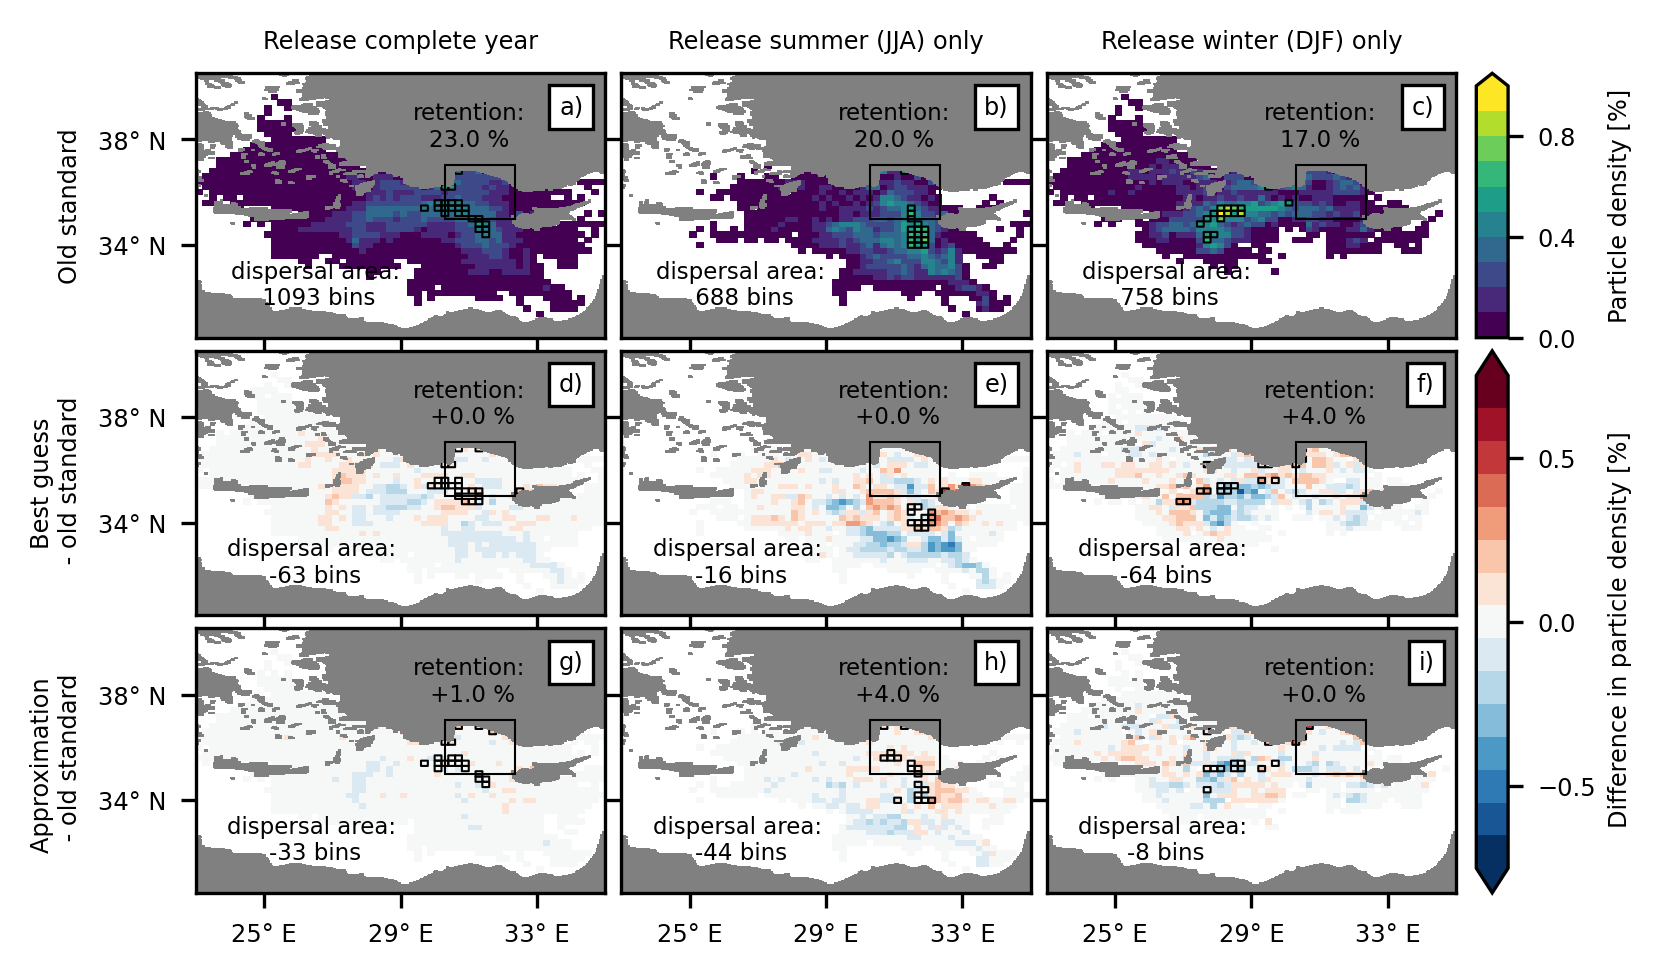

In [31]:

fig, gs, gscbar = create_newfig()


# Total distributions

ax = fig.add_subplot(gs[1, 0])
var1 = traj_nc
var2 = dist_nc
map = build_subplot_hist(var1, xticklabel=False)
ax.set_title('Release complete year', fontsize=fs)
ax.set_ylabel('Old standard', fontsize=fs)
utils.label_subplot(ax, 'a)', lw=lw_box, fs=fs, loc='upper right')

ax = fig.add_subplot(gs[2, 0])
var1 = traj_csd
var2 = traj_nc
map = build_subplot_histdiff(var1, var2, highprob=True, xticklabel=False)
ax.set_ylabel('Best guess\n - old standard', fontsize=fs)
utils.label_subplot(ax, 'd)', lw=lw_box, fs=fs, loc='upper right')

ax = fig.add_subplot(gs[3, 0])
var1 = traj_ncsd
var2 = traj_nc
map = build_subplot_histdiff(var1, var2, highprob=True)
ax.set_ylabel('Approximation \n - old standard', fontsize=fs)
utils.label_subplot(ax, 'g)', lw=lw_box, fs=fs, loc='upper right')


# Summer distributions

start_use = summerslice

ax = fig.add_subplot(gs[1, 1])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot_hist(var1, xticklabel=False, yticklabel=False)
ax.set_title('Release summer (JJA) only', fontsize=fs)
utils.label_subplot(ax, 'b)', lw=lw_box, fs=fs, loc='upper right')

ax = fig.add_subplot(gs[2, 1])
var1 = traj_csd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot_histdiff(var1, var2, highprob=True, xticklabel=False, yticklabel=False)
utils.label_subplot(ax, 'e)', lw=lw_box, fs=fs, loc='upper right')

ax = fig.add_subplot(gs[3, 1])
var1 = traj_ncsd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot_histdiff(var1, var2, highprob=True, yticklabel=False)
utils.label_subplot(ax, 'h)', lw=lw_box, fs=fs, loc='upper right')


# Winter distributions

start_use = winterslice

ax = fig.add_subplot(gs[1, 2])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot_hist(var1, xticklabel=False, yticklabel=False)
ax.set_title('Release winter (DJF) only', fontsize=fs)
utils.label_subplot(ax, 'c)', lw=lw_box, fs=fs, loc='upper right')
ax.text(lonmax_plot + (lonmax_plot-lonmin_plot)/2.5,
        latmin_plot + (latmax_plot - latmin_plot)/2, 'Particle density [%]',
        ha='center', va='center', fontsize=fs, rotation=90)
cbaxes = fig.add_subplot(gscbar[1:2, 79:81])
cbar = plt.colorbar(map, cax=cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.minorticks_off()

ax = fig.add_subplot(gs[2, 2])
var1 = traj_csd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot_histdiff(var1, var2, highprob=True, xticklabel=False, yticklabel=False)
utils.label_subplot(ax, 'f)', lw=lw_box, fs=fs, loc='upper right')

ax = fig.add_subplot(gs[3, 2])
var1 = traj_ncsd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot_histdiff(var1, var2, highprob=True, yticklabel=False)
utils.label_subplot(ax, 'i)', lw=lw_box, fs=fs, loc='upper right')
ax.text(lonmax_plot + (lonmax_plot-lonmin_plot)/2.5,
        latmax_plot, 'Difference in particle density [%]',
        ha='center', va='center', fontsize=fs, rotation=90)
cbaxes = fig.add_subplot(gscbar[2:5, 79:81])
cbar = plt.colorbar(map, cax=cbaxes, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.minorticks_off()


fig.savefig('../figs/png/fig10.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
fig.savefig('../figs/png-transparent/fig10.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1,
            transparent=True)

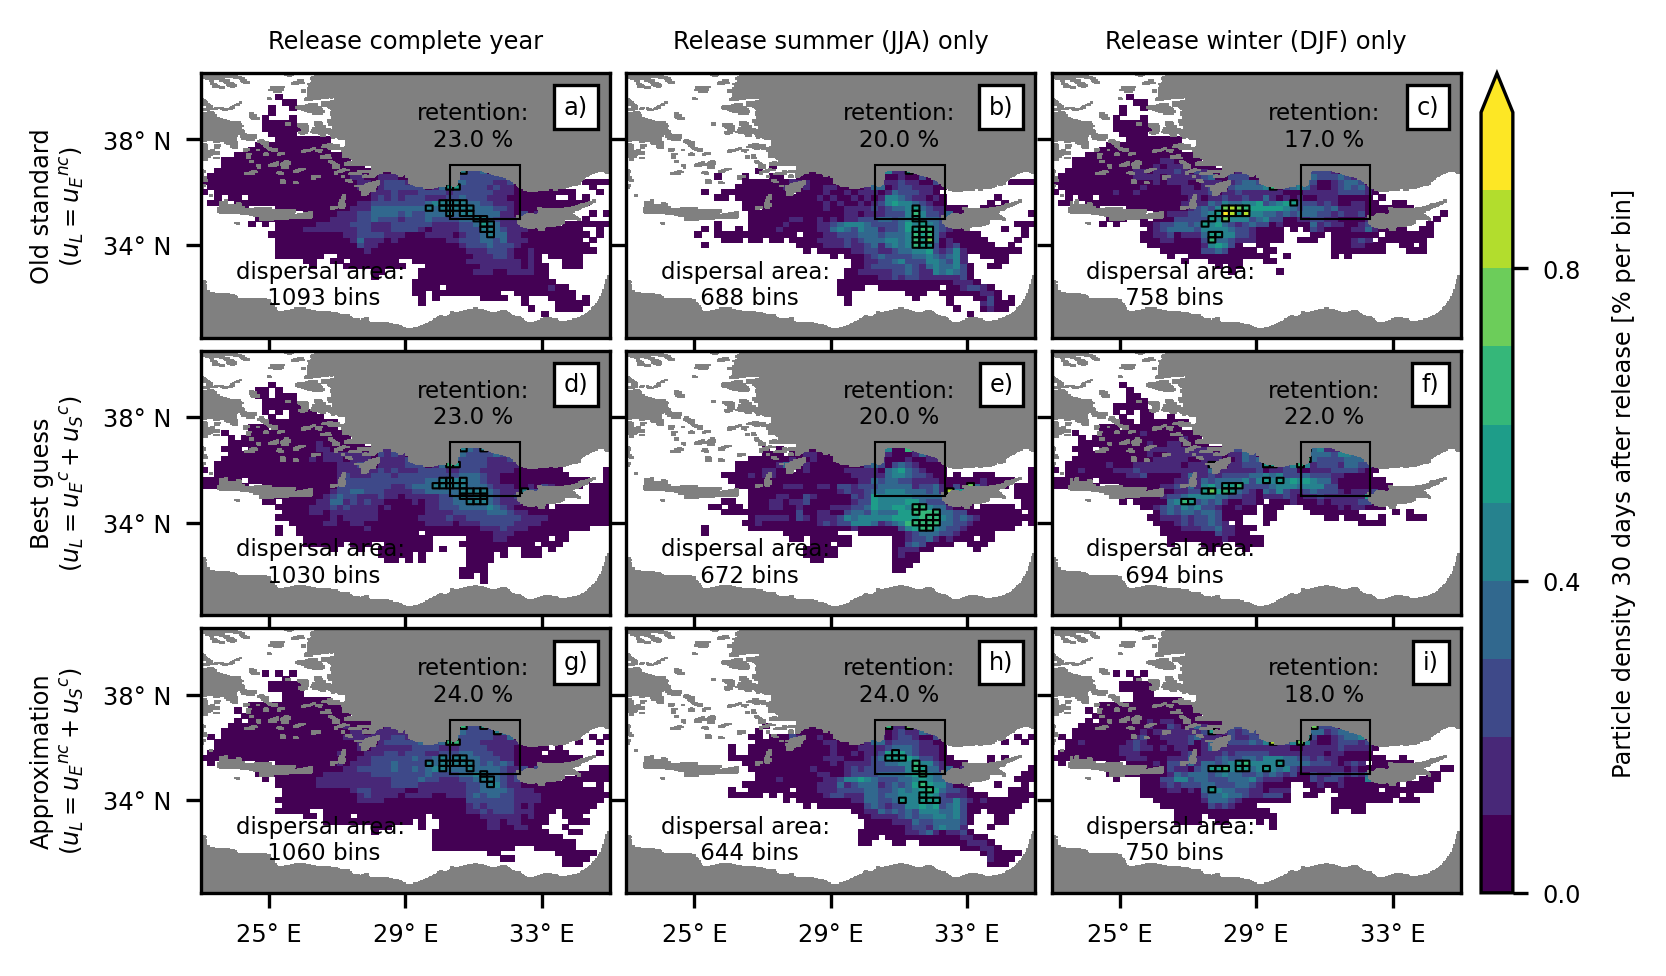

In [32]:
fig, gs, gscbar = create_newfig()


# Total distributions

ax = fig.add_subplot(gs[1, 0])
var1 = traj_nc
var2 = dist_nc
map = build_subplot_hist(var1, xticklabel=False)
ax.set_title('Release complete year', fontsize=fs)
ax.set_ylabel('Old standard\n($u_L = {u_E}^{nc}$)', fontsize=fs)
utils.label_subplot(ax, 'a)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[2, 0])
var1 = traj_csd
var2 = dist_csd
map = build_subplot_hist(var1, xticklabel=False)
ax.set_ylabel('Best guess\n($u_L = {u_E}^{c} + {u_S}^{c}$)', fontsize=fs)
utils.label_subplot(ax, 'd)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[3, 0])
var1 = traj_ncsd
var2 = dist_ncsd
map = build_subplot_hist(var1)
ax.set_ylabel('Approximation\n($u_L = {u_E}^{nc} + {u_S}^{c}$)', fontsize=fs)
utils.label_subplot(ax, 'g)', fs=fs, lw=lw_box, loc='upper right')


# Summer distributions

start_use = summerslice

ax = fig.add_subplot(gs[1, 1])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot_hist(var1, xticklabel=False, yticklabel=False)
ax.set_title('Release summer (JJA) only', fontsize=fs)
utils.label_subplot(ax, 'b)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[2, 1])
var1 = traj_csd.isel(start=start_use)
var2 = dist_csd.isel(start=start_use)
map = build_subplot_hist(var1, xticklabel=False, yticklabel=False)
utils.label_subplot(ax, 'e)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[3, 1])
var1 = traj_ncsd.isel(start=start_use)
var2 = dist_ncsd.isel(start=start_use)
map = build_subplot_hist(var1, yticklabel=False)
utils.label_subplot(ax, 'h)', fs=fs, lw=lw_box, loc='upper right')


# Winter distributions

start_use = winterslice

ax = fig.add_subplot(gs[1, 2])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot_hist(var1, xticklabel=False, yticklabel=False)
ax.set_title('Release winter (DJF) only', fontsize=fs)
utils.label_subplot(ax, 'c)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[2, 2])
var1 = traj_csd.isel(start=start_use)
var2 = dist_csd.isel(start=start_use)
map = build_subplot_hist(var1, xticklabel=False, yticklabel=False)
ax.text(lonmax_plot + (lonmax_plot-lonmin_plot)/2.5, latmin_plot + (latmax_plot-latmin_plot)/2,
        'Particle density 30 days after release [% per bin]',
        ha='center', va='center', fontsize=fs, rotation=90)
utils.label_subplot(ax, 'f)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[3, 2])
var1 = traj_ncsd.isel(start=start_use)
var2 = dist_ncsd.isel(start=start_use)
map = build_subplot_hist(var1, yticklabel=False)
utils.label_subplot(ax, 'i)', fs=fs, lw=lw_box, loc='upper right')
cbaxes = fig.add_subplot(gscbar[1:5, 79:81])
cbar = plt.colorbar(map, cax=cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.minorticks_off()


fig.savefig('../figs/png/figS6.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
fig.savefig('../figs/png-transparent/figS6.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1,
            transparent=True)

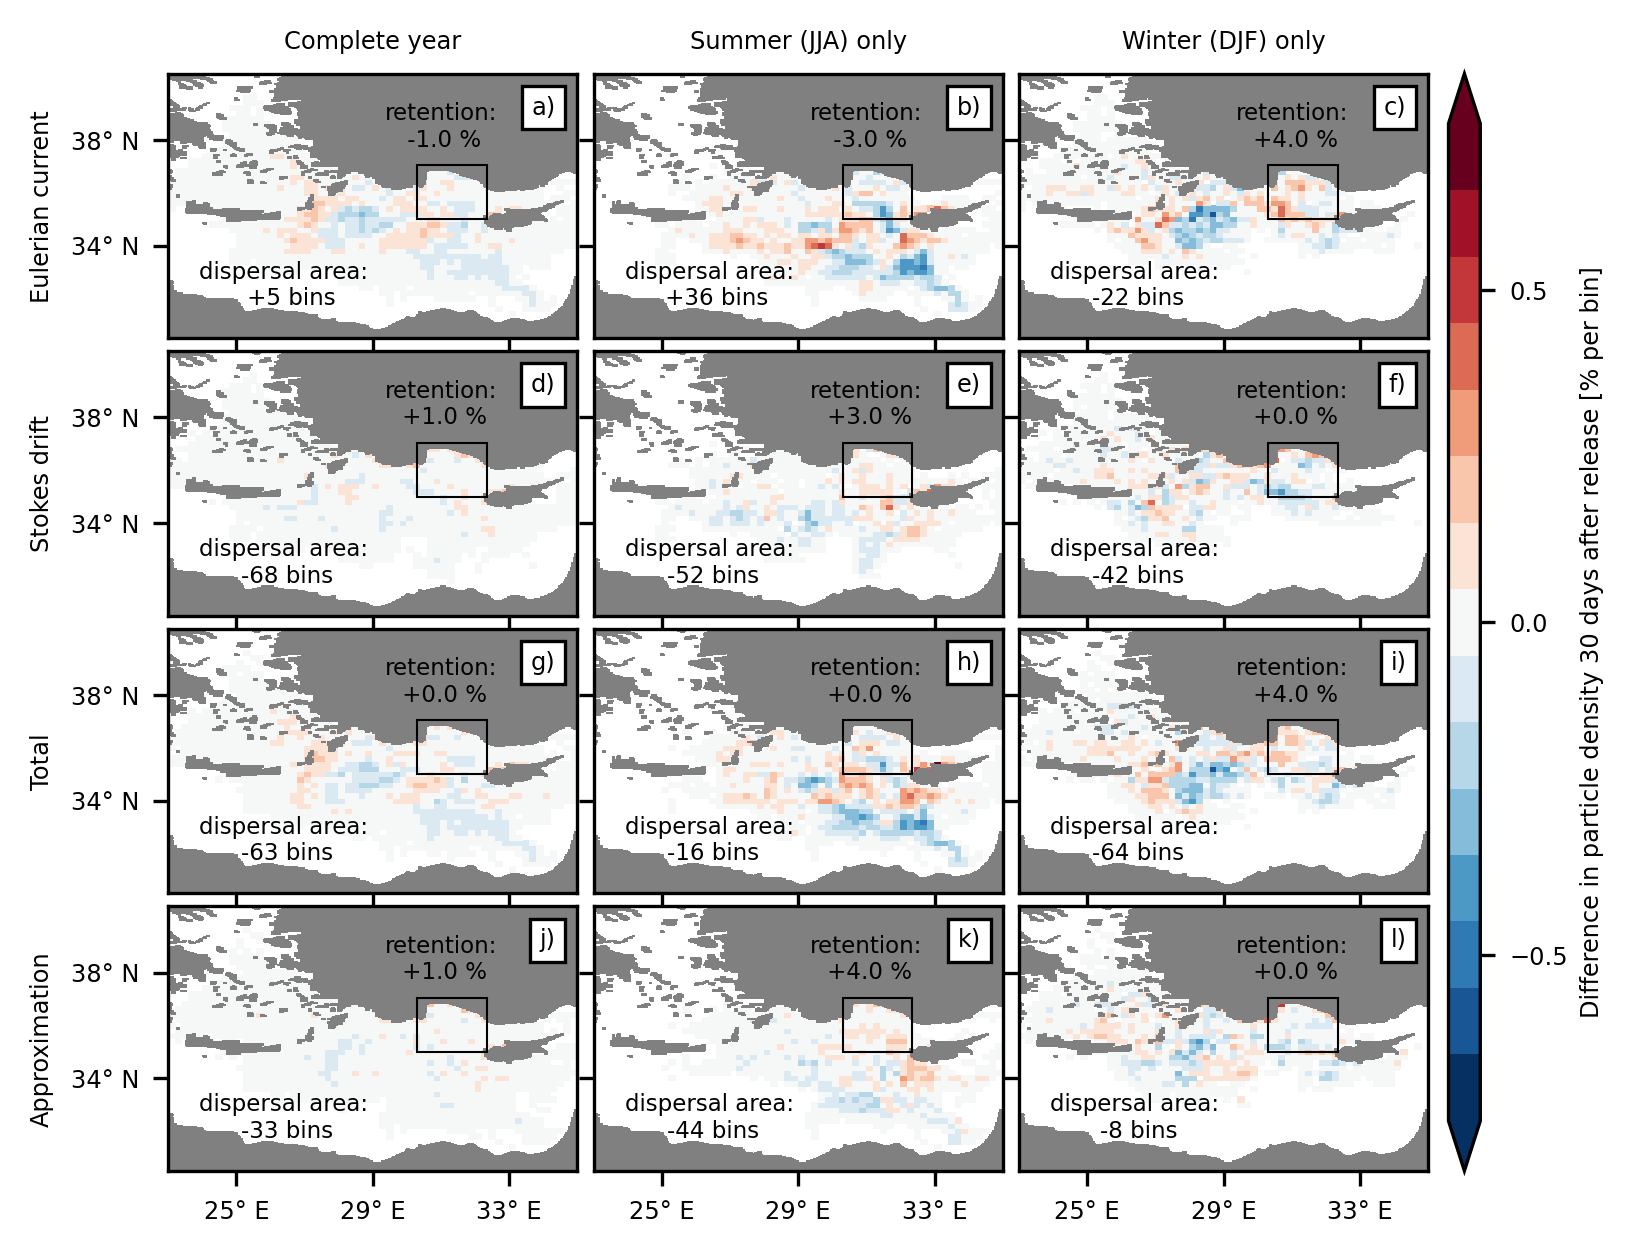

In [33]:
fig, gs, gscbar = create_newfig()


# Totel distributions

ax = fig.add_subplot(gs[0, 0])
var1 = traj_cnosd
var2 = traj_nc
map = build_subplot_histdiff(var1, var2, xticklabel=False)
ax.set_title('Complete year', fontsize=fs)
ax.set_ylabel('Eulerian current', fontsize=fs)
utils.label_subplot(ax, 'a)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[1, 0])
var1 = traj_csd
var2 = traj_cnosd
map = build_subplot_histdiff(var1, var2, xticklabel=False)
ax.set_ylabel('Stokes drift', fontsize=fs)
utils.label_subplot(ax, 'd)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[2, 0])
var1 = traj_csd
var2 = traj_nc
map = build_subplot_histdiff(var1, var2, xticklabel=False)
ax.set_ylabel('Total', fontsize=fs)
utils.label_subplot(ax, 'g)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[3, 0])
var1 = traj_ncsd
var2 = traj_nc
map = build_subplot_histdiff(var1, var2)
ax.set_ylabel('Approximation', fontsize=fs)
utils.label_subplot(ax, 'j)', fs=fs, lw=lw_box, loc='upper right')


# Summer distributions

start_use = summerslice

ax = fig.add_subplot(gs[0, 1])
var1 = traj_cnosd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot_histdiff(var1, var2, xticklabel=False, yticklabel=False)
ax.set_title('Summer (JJA) only', fontsize=fs)
utils.label_subplot(ax, 'b)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[1, 1])
var1 = traj_csd.isel(start=start_use)
var2 = traj_cnosd.isel(start=start_use)
map = build_subplot_histdiff(var1, var2, xticklabel=False, yticklabel=False)
utils.label_subplot(ax, 'e)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[2, 1])
var1 = traj_csd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot_histdiff(var1, var2, xticklabel=False, yticklabel=False)
utils.label_subplot(ax, 'h)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[3, 1])
var1 = traj_ncsd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot_histdiff(var1, var2, yticklabel=False)
utils.label_subplot(ax, 'k)', fs=fs, lw=lw_box, loc='upper right')


# Winter distributions

start_use = winterslice

ax = fig.add_subplot(gs[0, 2])
var1 = traj_cnosd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot_histdiff(var1, var2, xticklabel=False, yticklabel=False)
ax.set_title('Winter (DJF) only', fontsize=fs)
utils.label_subplot(ax, 'c)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[1, 2])
var1 = traj_csd.isel(start=start_use)
var2 = traj_cnosd.isel(start=start_use)
map = build_subplot_histdiff(var1, var2, xticklabel=False, yticklabel=False)
utils.label_subplot(ax, 'f)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[2, 2])
var1 = traj_csd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot_histdiff(var1, var2, xticklabel=False, yticklabel=False)
utils.label_subplot(ax, 'i)', fs=fs, lw=lw_box, loc='upper right')

ax = fig.add_subplot(gs[3, 2])
var1 = traj_ncsd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot_histdiff(var1, var2, yticklabel=False)
ax.text(lonmax_plot + (lonmax_plot-lonmin_plot)/2.5, latmax_plot + (latmax_plot - latmin_plot),
        'Difference in particle density 30 days after release [% per bin]',
        ha='center', va='center', fontsize=fs, rotation=90)
utils.label_subplot(ax, 'l)', fs=fs, lw=lw_box, loc='upper right')
cbaxes = fig.add_subplot(gscbar[0:5, 79:81])
cbar = plt.colorbar(map, cax=cbaxes, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.minorticks_off()


fig.savefig('../figs/png/figS7.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
fig.savefig('../figs/png-transparent/figS7.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1,
            transparent=True)